# Introduction

The goal of this notebook is to attempt to create an ARIMA model to predict future sales data using the data given in https://www.kaggle.com/c/demand-forecasting-kernels-only. The main reference material used was from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = ['date'], index_col = ['date'])

In [3]:
# Separate sample data set
train1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index < '2017-10-01'), 'sales']
val1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index >= '2017-10-01'), 'sales']

/Users/Philip/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([736330., 736361., 736389., 736420., 736450., 736481., 736511.,
        736542., 736573., 736603.]), <a list of 10 Text xticklabel objects>)

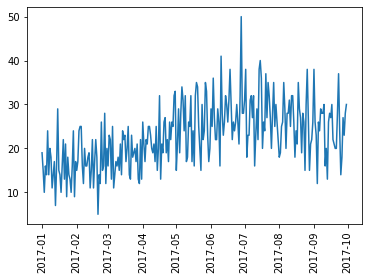

In [4]:
# Plot training data
plt.plot(train1_1.loc[(train1_1.index >= '2017-01-01')])
plt.xticks(rotation=90)

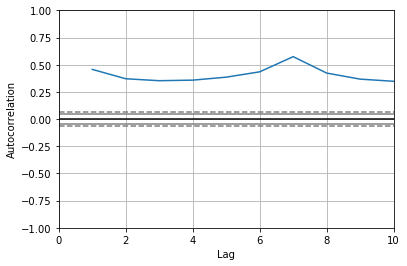

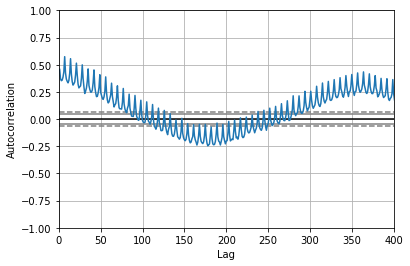

In [5]:
#Plot autocorrelation data

plt.figure(1)
autocorrelation_plot(train1_1)
plt.xlim(0, 10)
plt.figure(2)
autocorrelation_plot(train1_1)
plt.xlim(0, 400)
plt.show()

As it can be seen, there is a peak in autocorrelation with lags around 7 and 365. This is likely because there is a mixture of weekly and annual trends.

# Model Fitting

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(8, 1, 2)   Log Likelihood               -5284.898
Method:                       css-mle   S.D. of innovations              5.104
Date:                Thu, 20 Feb 2020   AIC                          10593.795
Time:                        14:12:16   BIC                          10659.286
Sample:                    01-02-2013   HQIC                         10618.017
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0076      0.012      0.639      0.523      -0.016       0.031
ar.L1.D.sales    -0.8806      0.065    -13.596      0.000      -1.008      -0.754
ar.L2.D.sales    -0.0429      0.049     

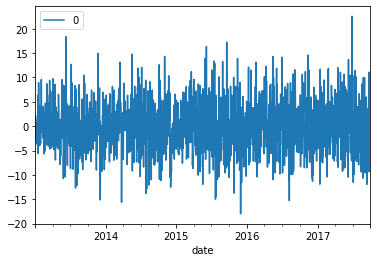

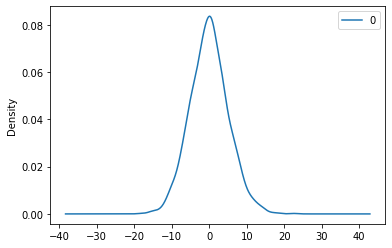

                 0
count  1733.000000
mean     -0.005143
std       5.105488
min     -18.017008
25%      -3.374577
50%      -0.037741
75%       3.204829
max      22.559304


In [6]:
# Fit model on ARIMA
model = ARIMA(train1_1, order = (8,1,2), freq = 'D')
model_fit = model.fit(disp = 0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind = 'kde')
plt.show()
print(residuals.describe())

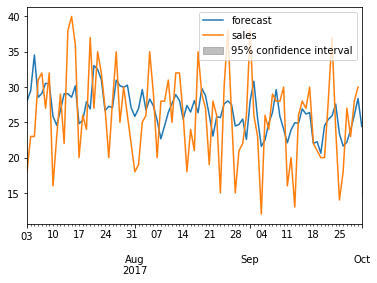

In [7]:
prediction = model_fit.plot_predict(len(train1_1)-90,len(train1_1))

# Forecasting and Validation

In [8]:
history = [x for x in train1_1]
predictions = list()

for t in range(len(val1_1)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = val1_1[t]
    history.append(obs)

In [24]:
model = ARIMA(train1_1, order = (7,1,0), freq = 'D')
model_fit = model.fit(disp=0)
#output = model_fit.predict(start = '2017-09-01', end = '2017-12-31', dynamic = True)
output = model_fit.forecast(steps = len(val1_1))

In [10]:
def SMAPE(y_true, y_pred):
    """ Returns the standard mean absolute percent error in %
    """
    return np.mean(200*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

Validation MSE: 53.207
Validation SMAPE: 29.359%


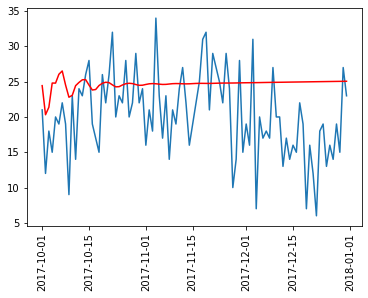

In [22]:
predictions = pd.Series(output[0])
predictions.index = val1_1.index

error = mean_squared_error(val1_1, predictions)
print('Validation MSE: {:.3f}'.format(error))
print('Validation SMAPE: {:.3f}%'.format(SMAPE(val1_1, predictions)))
# plot
plt.plot(val1_1)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

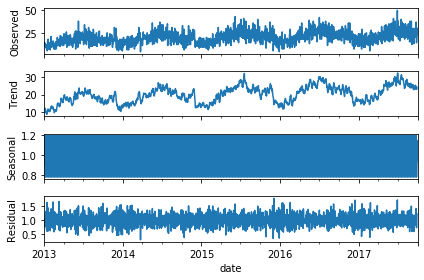

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train1_1, model='multiplicative')
fig = result.plot()

# Conclusion

The ARIMA model seems to work fine. With an validation mean squared error of 51.4 and an SMAPE of 29.4%, The ARIMA model doesn't seem to capture any of the seasonal trends in its forecasts. Considering the seasonal component of the data, we should consider using a SARIMAX model.